In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
path = r"D:\Users\amosc\Documents\Coding\Thesis\THS-ST3\Code\outputs\Test\Test_noise_outs"
images = []
for image in os.listdir(path):
    if os.path.isfile(os.path.join(path, image)):
        images.append(cv2.imread(os.path.join(path, image)))
images

[array([[[239, 235, 255],
         [  0,   0,  24],
         [192, 190, 160],
         ...,
         [244, 246, 255],
         [226, 225, 255],
         [ 40,  38, 168]],
 
        [[255, 238, 255],
         [ 79,  66,  92],
         [255, 255, 237],
         ...,
         [  0,   0,  17],
         [ 57,  56, 128],
         [222, 221, 255]],
 
        [[255, 241, 255],
         [ 29,   0,   3],
         [  9,   2,   0],
         ...,
         [  0,   0,   4],
         [  0,   0,  17],
         [  0,   0,  25]],
 
        ...,
 
        [[255, 243, 255],
         [255, 233, 255],
         [237, 223, 255],
         ...,
         [ 60,  54, 136],
         [246, 242, 255],
         [  0,   0,  13]],
 
        [[  0,   0,  35],
         [  0,   0,  50],
         [ 48,  42, 151],
         ...,
         [ 83,  52, 121],
         [243, 233, 255],
         [ 64,  64, 112]],
 
        [[  0,   0,  48],
         [ 51,  52, 133],
         [225, 221, 255],
         ...,
         [ 22,   0,  39],
  

In [3]:
#images = list(map(lambda x: np.sum(x, axis=2), images))
for i, image in enumerate(images):
    image = np.sum(image, axis=2)
    image = image / 255
    images[i] = image
heatmap = np.sum(images, axis=0)

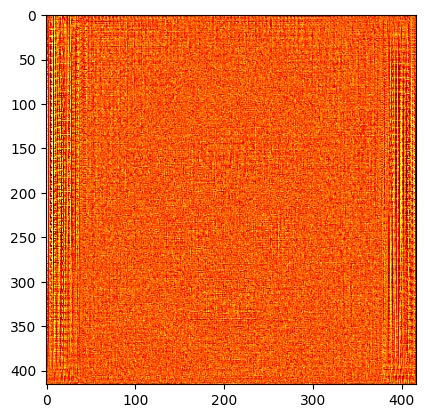

In [4]:
plt.imshow(heatmap, cmap='hot')
plt.show()

___